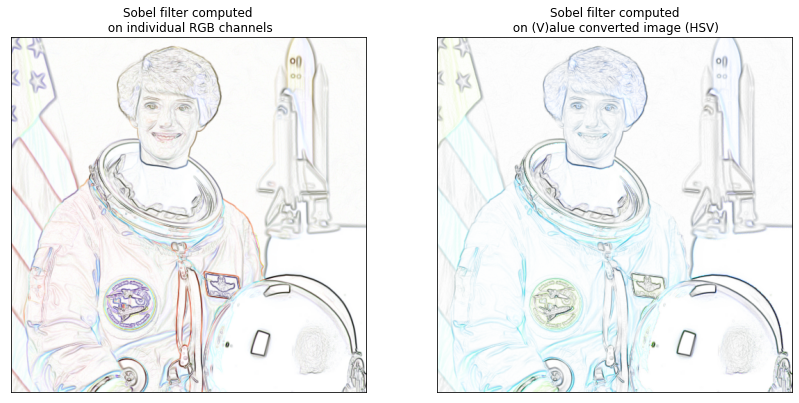

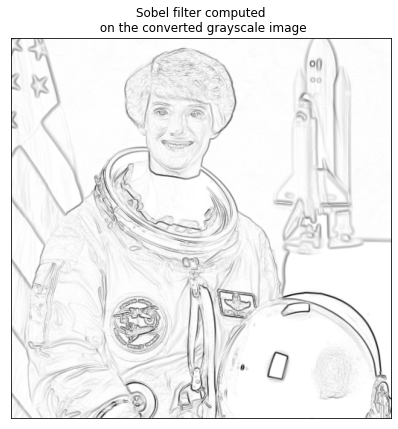

In [1]:
"""
=========================================
Adapting gray-scale filters to RGB images
=========================================

There are many filters that are designed to work with gray-scale images but not
with color images. To simplify the process of creating functions that can adapt
to RGB images, scikit-image provides the ``adapt_rgb`` decorator.

To actually use the ``adapt_rgb`` decorator, you have to decide how you want to
adapt the RGB image for use with the gray-scale filter. There are two
pre-defined handlers:

``each_channel``
    Pass each of the RGB channels to the filter one-by-one, and stitch the
    results back into an RGB image.
``hsv_value``
    Convert the RGB image to HSV and pass the value channel to the filter.
    The filtered result is inserted back into the HSV image and converted
    back to RGB.

Below, we demonstrate the use of ``adapt_rgb`` on a couple of gray-scale
filters:
"""
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters


@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)


######################################################################
# We can use these functions as we would normally use them, but now they work
# with both gray-scale and color images. Let's plot the results with a color
# image:

from skimage import data
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

image = data.astronaut()

fig, (ax_each, ax_hsv) = plt.subplots(ncols=2, figsize=(14, 7))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)))
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Sobel filter computed\n on individual RGB channels")

# We use 1 - sobel_hsv(image) but this won't work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)))
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

######################################################################
# Notice that the result for the value-filtered image preserves the color of
# the original image, but channel filtered image combines in a more
# surprising way. In other common cases, smoothing for example, the channel
# filtered image will produce a better result than the value-filtered image.
#
# You can also create your own handler functions for ``adapt_rgb``. To do so,
# just create a function with the following signature::
#
#     def handler(image_filter, image, *args, **kwargs):
#         # Manipulate RGB image here...
#         image = image_filter(image, *args, **kwargs)
#         # Manipulate filtered image here...
#         return image
#
# Note that ``adapt_rgb`` handlers are written for filters where the image is
# the first argument.
#
# As a very simple example, we can just convert any RGB image to grayscale
# and then return the filtered result:

from skimage.color import rgb2gray


def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

######################################################################
# It's important to create a signature that uses ``*args`` and ``**kwargs``
# to pass arguments along to the filter so that the decorated function is
# allowed to have any number of positional and keyword arguments.
#
# Finally, we can use this handler with ``adapt_rgb`` just as before:


@adapt_rgb(as_gray)
def sobel_gray(image):
    return filters.sobel(image)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

# We use 1 - sobel_gray(image) but this won't work if image is not normalized
ax.imshow(rescale_intensity(1 - sobel_gray(image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Sobel filter computed\n on the converted grayscale image")

plt.show()

######################################################################
#
# .. note::
#
#     A very simple check of the array shape is used for detecting RGB
#     images, so ``adapt_rgb`` is not recommended for functions that support
#     3D volumes or color images in non-RGB spaces.
